When training deep learning models, monitoring the training process and stopping at the right time are crucial for developing effective models. Neural network callbacks are special functions that are automatically called at specific points during training, allowing you to implement monitoring strategies and automate key decisions.

In this lesson, we'll focus on implementing early stopping and monitoring training progress. Early stopping automatically terminates training when model performance stops improving, which helps prevent overfitting and saves valuable computation time. We'll use a real example with the MNIST dataset to show you exactly how to implement these crucial techniques in your own neural networks.

##### Step 1: Import Necessary Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import random

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

##### Step 2: Load and Preprocess the Data

In [2]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert labels to categorical one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

11490434/11490434 [==============================] - 0s 0us/step


##### Step 3: Create a Simple Neural Network Model

In [3]:
# Create a simple model
model = Sequential([
    Input((28, 28)),
    Flatten(), # need to flatten 28x28 image matrices into vectors
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax') # softmax output activation for multi-class
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # categorical not binary for multi-class
    metrics=['accuracy']
)

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


##### Step 4: Create Callbacks for Early Stopping and Training Monitoring

In [4]:
# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss
    patience=5,               # Number of epochs with no improvement after which to stop
    min_delta=0.001,          # Minimum change to qualify as improvement
    restore_best_weights=True # Restore model weights from the epoch with the best value
)

# Model checkpoint callback to save the best model
checkpoint_filepath = './best_model.keras'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,      # Only save when there's improvement
    mode='min',               # The direction is 'min' for loss
    verbose=1                 # Show progress
)

# TensorBoard callback for visualization
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1          # Update histograms every epoch
)

# Combine callbacks into a list
callbacks = [
    early_stopping,
    model_checkpoint,
    tensorboard_callback
]

##### Step 5: Train the Model with Callbacks

In [5]:
# Train the model with callbacks
history = model.fit(
    x_train, y_train,
    epochs=100,                # Set a high number, early stopping will halt training if needed
    batch_size=128,
    validation_split=0.2,     # Use 20% of training data for validation
    callbacks=callbacks,      # Pass the callbacks list here
    verbose=1
)

Epoch 1/100
368/375 [============================>.] - ETA: 0s - loss: 0.3686 - accuracy: 0.8994
Epoch 1: val_loss improved from inf to 0.18793, saving model to .\best_model.keras
375/375 [==============================] - 2s 3ms/step - loss: 0.3657 - accuracy: 0.9000 - val_loss: 0.1879 - val_accuracy: 0.9453
Epoch 2/100
354/375 [===========================>..] - ETA: 0s - loss: 0.1566 - accuracy: 0.9537
Epoch 2: val_loss improved from 0.18793 to 0.15254, saving model to .\best_model.keras
375/375 [==============================] - 1s 3ms/step - loss: 0.1553 - accuracy: 0.9539 - val_loss: 0.1525 - val_accuracy: 0.9556
Epoch 3/100
349/375 [==========================>...] - ETA: 0s - loss: 0.1121 - accuracy: 0.9657
Epoch 3: val_loss improved from 0.15254 to 0.11985, saving model to .\best_model.keras
375/375 [==============================] - 1s 2ms/step - loss: 0.1107 - accuracy: 0.9661 - val_loss: 0.1199 - val_accuracy: 0.9640
Epoch 4/100
367/375 [============================>.] - ETA:

##### Step 6: Visualize the Training History

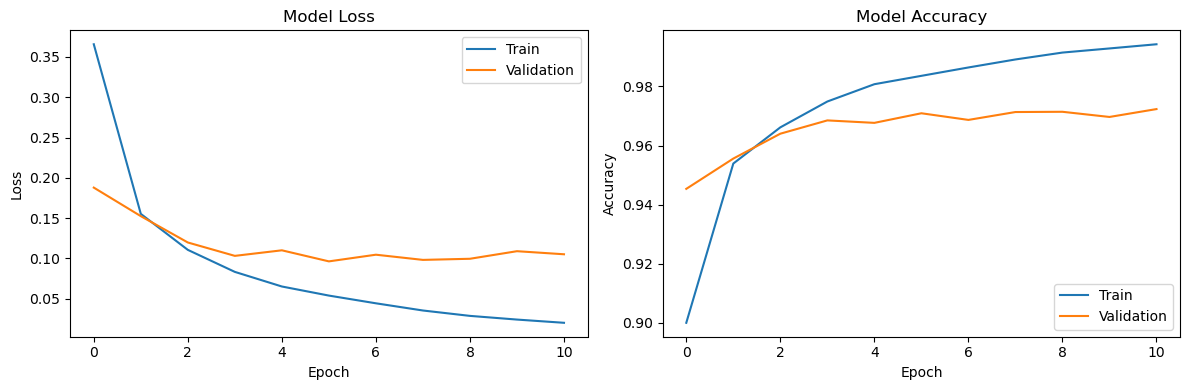

Training stopped at epoch 11


In [6]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

# Print the epoch where training stopped
print(f"Training stopped at epoch {len(history.history['loss'])}")

##### Step 7: Launch and Use TensorBoard

In [9]:
# In your notebook or Python script, run:
#%load_ext tensorboard
#%tensorboard --logdir=logs/fit

# Alternatively, from a terminal/command prompt:
#tensorboard --logdir=logs/fit

##### Step 8: Load the Best Model and Evaluate It

In [10]:
# Load the best model saved by ModelCheckpoint
best_model = tf.keras.models.load_model(checkpoint_filepath)

# Evaluate on test data
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

313/313 - 0s - loss: 0.0907 - accuracy: 0.9731 - 422ms/epoch - 1ms/step
Test accuracy: 0.9731


##### Step 9: Understanding and Addressing Gradient Problems

In [11]:
# Add a callback to monitor gradient norms
class GradientMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        grads = self.model.optimizer.get_gradients(self.model.total_loss, self.model.trainable_weights)
        norm = tf.sqrt(sum([tf.reduce_sum(tf.square(g)) for g in grads]))
        print(f"Epoch {epoch}: Gradient norm: {norm}")
        
# Add this to your callbacks list
gradient_monitor = GradientMonitor()
callbacks.append(gradient_monitor)

**Exploding Gradients**

1. Gradient clipping: limits maximum size of gradients

In [12]:
# Apply gradient clipping when compiling the model
from tensorflow.keras.optimizers import Adam

optimizer = Adam(clipnorm=1.0)  # Clip gradients to a maximum norm of 1
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

2. Reduce learning rate: use a smaller learning rate or implement learning rate reduction

In [13]:
# Add ReduceLROnPlateau callback
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,            # Reduce learning rate by 80%
    patience=3,            # Wait 3 epochs of no improvement
    min_lr=0.00001         # Don't go below this learning rate
)
callbacks.append(reduce_lr)

3. Batch normalization: add batch normalization layers to the model

In [ ]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Input((28, 28)),
    Flatten(),
    Dense(128),
    BatchNormalization(),  # Add batch normalization after Dense layers
    Activation('relu'),    # Activation function applied after normalization
    Dense(64),
    BatchNormalization(),
    Activation('relu'),
    Dense(10, activation='softmax')
])

**Vanishing Gradients**

Signs of vanishing gradients:

- Training plateaus early despite low accuracy
- Later layers improve while early layers remain unchanged
- Using TensorBoard histograms to observe weight updates across layers

*Solutions for vanishing gradients*

1. Use ReLU and its variants: replace activation function with more advanced ReLU family activations

In [15]:
# Try LeakyReLU instead of regular ReLU
from tensorflow.keras.layers import LeakyReLU

model = Sequential([
    Input((28, 28)),
    Flatten(),
    Dense(128),
    LeakyReLU(alpha=0.1),  # LeakyReLU allows small negative values
    Dense(64),
    LeakyReLU(alpha=0.1),
    Dense(10, activation='softmax')
])

2. Use proper weight initialization: choose methods that help prevent vanishing gradients

In [ ]:
# Use He initialization for ReLU networks
model = Sequential([
    Input((28, 28)),
    Flatten(),
    Dense(128, kernel_initializer='he_normal'),
    Activation('relu'),
    Dense(64, kernel_initializer='he_normal'),
    Activation('relu'),
    Dense(10, activation='softmax')
])

3. Use skip connections: implement residual connections (as in ResNet); outside the scope of this lesson

*Connections to Early Stopping*

- Early stopping might activate prematurely if vanishing gradients cause training to plateau
- Exploding gradients can cause wild fluctuations that trigger early stopping
- A well-tuned model with proper gradient handling often trains longer before stopping activates